<a href="https://colab.research.google.com/github/rostro36/Partisan-Responses/blob/master/08_Coref%26Knowledge_Graph_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Partisan-Responses-master')

Install all requirements.

In [ ]:
!pip install torchtext -U
!pip install spacy==2.1.0
!pip install neuralcoref allennlp hnswlib allennlp-models
!python -m spacy download en
!pip install wandb

Import everything

In [ ]:
import neuralcoref
import spacy
import re
import pickle
import pandas as pd
import gc
from Answer import Answer
import utils
from Speech import Speech
from KnowledgeGraph import KnowledgeGraph
import nltk

Load search results

In [ ]:
df = pd.read_pickle("search_results.pkl")

Setup everything for coref

In [ ]:
nlp = spacy.load('en')
neuralcoref.add_to_pipe(nlp)

identifier='coref'
last_check=0
step_size=1000

def load_pickles(identifier, checkpoint):
  if os.path.exists("df"+identifier+str(checkpoint)+".pickle"):
    df = pd.read_pickle("df"+identifier+str(checkpoint)+".pickle")
  return df

def dump_pickles(identifier, checkpoint, df):
  df.to_pickle("df"+identifier+str(checkpoint)+".pickle")
  gc.collect()
  return 

def make_corefs(content):
    content=str(re.sub("\.(?=\s[a-z0-9]|\sI[\W\s])", ",", content))
    doc=nlp(content)
    return doc._.coref_resolved

df = pd.read_pickle("final_data.pkl")

Do coref

In [ ]:
for i in range(last_check+1,int(df.shape[0]/step_size)):
  print(i)
  for j in range(step_size):
    df.iloc[step_size*(i-1)+j]['answer']=make_corefs(df.iloc[step_size*(i-1)+j]['answer'])
  dump_pickles(identifier,i,df)
print('done with ordered')
for j in range(df.shape[0]-int(df.shape[0]/step_size)*step_size):
  df.iloc[step_size*int(df.shape[0]/step_size)+j]['answer']=make_corefs(df.iloc[step_size*int(df.shape[0]/step_size)+j]['answer'])
df.to_pickle(identifier+".pkl")

done with ordered


In [ ]:
auxillary_verbs=['can','could','may','might','must','shall','should','will','would'] #https://englishstudyonline.org/auxiliary-verbs/
distance_threshold=0.5

class Speech:
    def __init__(self, speech):
        #self.speaker = speech['lastname'] + " " + speech['firstname']
        self.party = speech['party']
        self.content = speech['speech']
        
    def change_comma(self):
        """
        Replace improper period to comma
        """
        self.content = re.sub("\.(?=\s[a-z0-9]|\sI[\W\s])", ",", self.content)

    def _find_triplets(self, openinfo_result):
        """
        Find one or more triplets of each sentence from allennlp OIE results
        Param:
        ========
        Return:
        ========
        speech_triplets: list, a list of lists of triplet tuples (of a speech)
        """
        arg0 = "ARG0: "
        arg1 = "ARG1: "
        modalverbs = ["can", "could", "may", "might", "must", "shall", "should", "will", "would"]
        speech_triplet = []
        for sentence in openinfo_result:
            sent_triplet = []
            if sentence is not []:
                for d in sentence: # Extract from 'description' result of OIE
                    verb = d['verb']
                    if verb not in modalverbs:
                        subjidx = d['description'].rfind(arg0) 
                        predidx = d['description'].rfind(arg1)
                        if subjidx != -1 and predidx != -1:
                            subj = re.search("(?<=ARG0: )[^\]]*(?=])", d['description']).group(0)
                            predicate = re.search("(?<=ARG1: )[^\]]*(?=])", d['description']).group(0)
                            
                            sent_triplet.append((subj, verb, predicate))
            speech_triplet.append(sent_triplet)
        return speech_triplet
                
    def create_triplet(self):
        """
        Generate (subject, verb, object) triplets of a speech text
        Param:
        ========
        coref_extractor: allennlp coreferece resolution predictor
        oi_extractor: allennlp open information extractor
        Return:
        ========
        triplets: list, a list of triplet tuples except the last item being party string
        """
        oie_result=self.create_oieresult()
        triplets = self._find_triplets(oie_result)
        triplets.append(self.party)
        return triplets
    
    def create_oieresult(self):
        coref_content = utils.coref_extractor.coref_resolved(self.content)
        sents = nltk.tokenize.sent_tokenize(coref_content)
        sents = [{"sentence":s} for s in sents] #Format for oie batch predictor
        oie_result = utils.open_info_extractor.predict_batch_json(sents)
        oie_result = [i['verbs'] for i in oie_result]
        return oie_result

In [ ]:
df.rename(columns={'answer': 'speech'}, inplace=True)
df.head()

,question,speech,party
0,Should abortion be illegal?,Mr. Speaker. Congress now has an opportunity t...,R
1,Should abortion be illegal?,"Mr. Speaker, I rise today to express my opposi...",R
2,Should abortion be illegal?,"so eloquently pointed out earlier, partialbirt...",R
3,Should abortion be illegal?,"Mr. Chairman, I rise in reluctant support of t...",D
4,Should abortion be illegal?,Will the Senator yield to answer a question so...,D


Initialize empty knowledge graphs

In [ ]:
knowledgeGraphs=dict()
for i in range(df.shape[0]):
  question=df.iloc[i,0]
  knowledgeGraphs[question]=KnowledgeGraph(question)

Build knowledge graph

In [ ]:
for i in range(df.shape[0]):
  question=df.iloc[i,0]
  drawer=False
  triplets=Speech(df.iloc[i]).create_triplet()
  if knowledgeGraphs[question].node_index is None:
    drawer=True
  knowledgeGraphs[question].add_edges(triplets)
  if drawer:
    knowledgeGraphs[knowledgeGraph].draw("start"+question[:10])

Draw knowledge graph

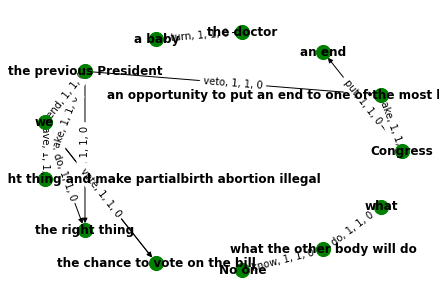

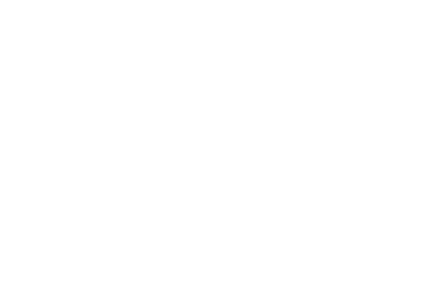

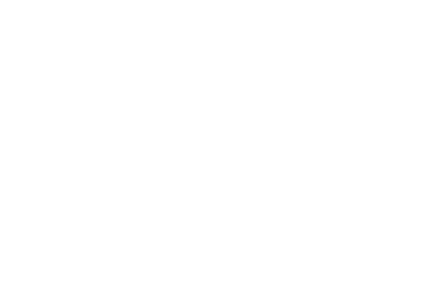

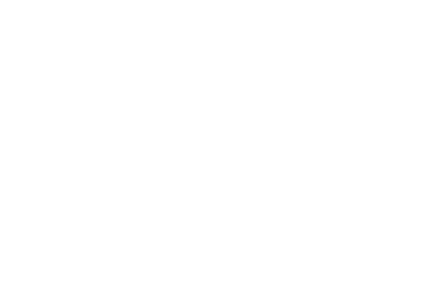

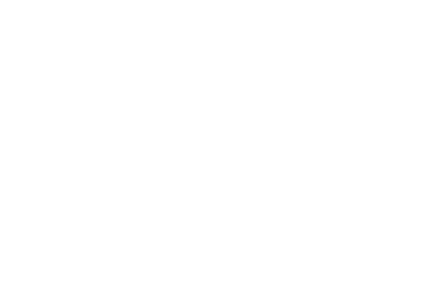

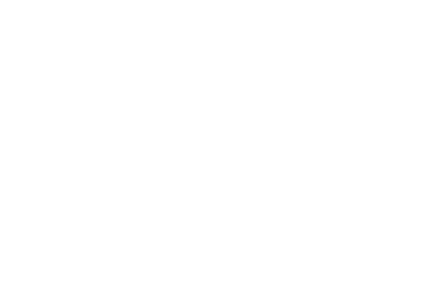

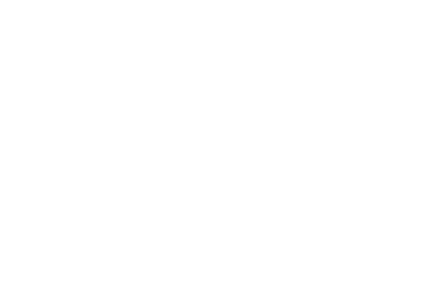

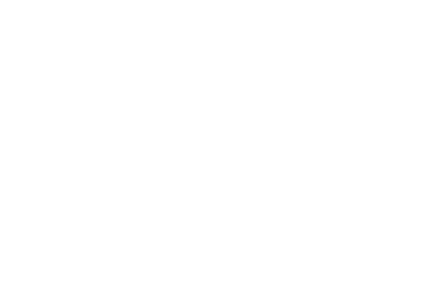

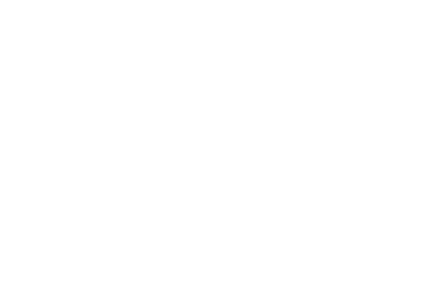

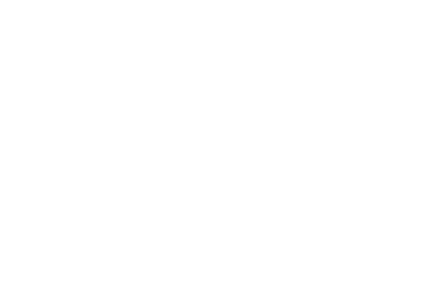

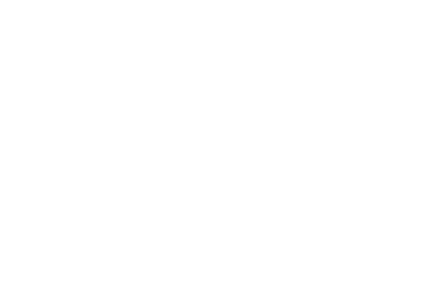

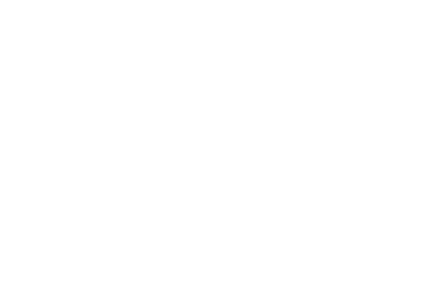

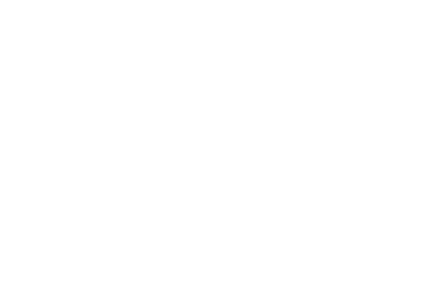

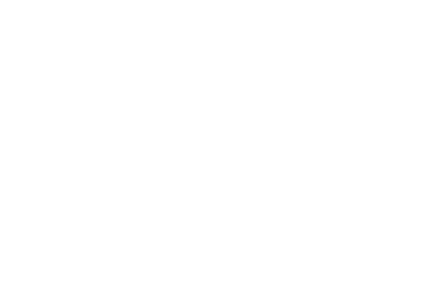

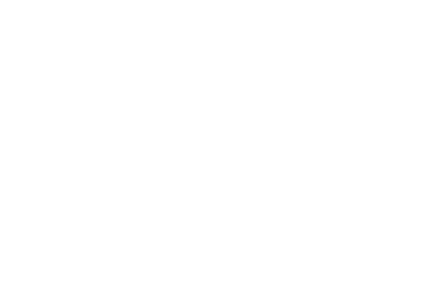

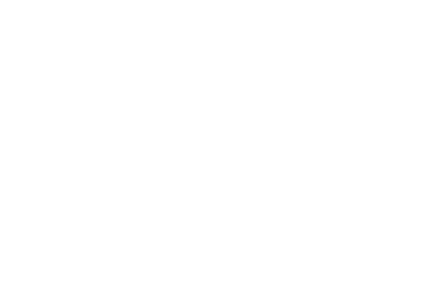

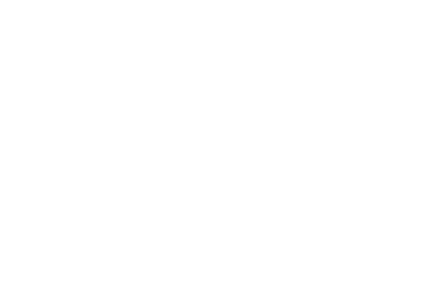

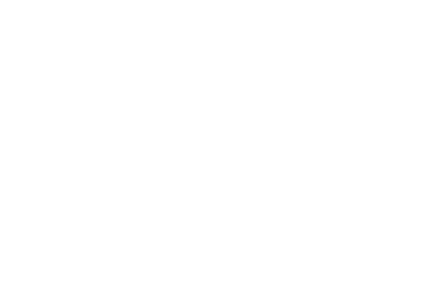

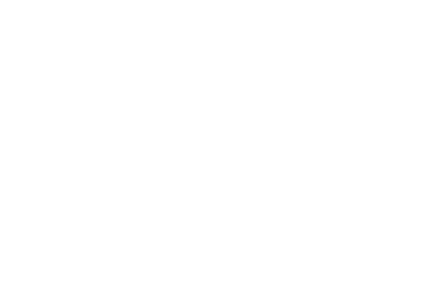

In [ ]:
for knowledgeGraph in knowledgeGraphs:
  knowledgeGraphs[knowledgeGraph].draw(knowledgeGraph[:10])